In [97]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as kr

In [98]:
img_height = 180
img_width = 180
batch_size = 32

train_ds = kr.utils.image_dataset_from_directory(
    "/kaggle/input/covid19-image-dataset/Covid19-dataset/train",
    seed = 123,
    image_size = (img_height,img_width)
)
test_ds = kr.utils.image_dataset_from_directory(
    "/kaggle/input/covid19-image-dataset/Covid19-dataset/test",
    seed = 123,
    image_size = (img_height,img_width)
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [99]:
class_names = train_ds.class_names

In [100]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  class_2 = labels == 2
  class_2 = tf.cast(class_0, tf.int32)
  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)
  counts['class_2'] += tf.reduce_sum(class_2)

  return counts

counts = train_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0, 'class_2' : 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy(),
                   counts['class_2']]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)


[0.380137   0.23972602 0.380137  ]


In [101]:
def class_func(features, label):
  return label

In [102]:
resample_ds = (
    train_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.33,0.33,0.33],
                        initial_dist=fractions)
    .batch(32))

In [103]:
balanced_train_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [104]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = balanced_train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [105]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,180,3),
    pooling="avg",
    classes=3,
    classifier_activation="softmax"
)



In [106]:
base_model.trainable = False

In [107]:
inputs = kr.Input(shape=(180,180,3))
mean = np.array([127.5]*3)
var = mean ** 2

norm_layer = kr.layers.experimental.preprocessing.Normalization(mean=mean,variance=var)
x = norm_layer(inputs)

x = base_model(x)

x = kr.layers.Dense(256)(x)
x = kr.layers.Dense(64)(x)
output = kr.layers.Dense(3, activation="softmax")(x)
model_fin = kr.Model(inputs,output)

In [108]:
model_fin.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 normalization_5 (Normaliza  (None, 180, 180, 3)       0         
 tion)                                                           
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_15 (Dense)            (None, 256)               524544    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                           

In [109]:
optimzer = kr.optimizers.Adam(learning_rate=0.000001)
model_fin.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [110]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)


In [112]:
history = model_fin.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    callbacks = [early_stop],
    shuffle = True,
)

Epoch 1/2


Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.38013

9/9 [==============================] - 19s 2s/step - loss: 0.6603 - accuracy: 0.8214 - val_loss: 1.3413 - val_accuracy: 0.8030
Epoch 2/2
9/9 [==============================] - 15s 2s/step - loss: 0.4118 - accuracy: 0.8786 - val_loss: 0.7316 - val_accuracy: 0.8485


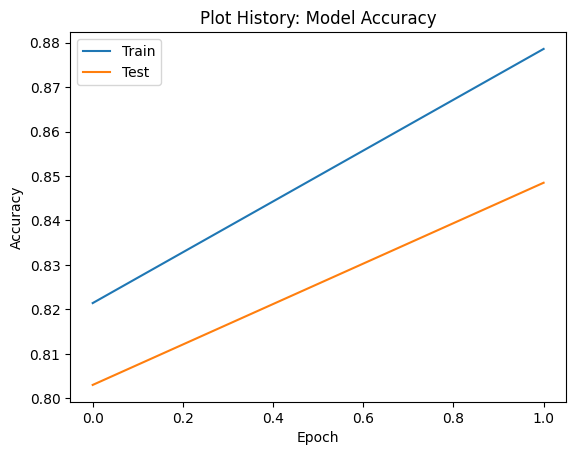

In [114]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [115]:
y_pred = np.argmax(model_fin.predict(val_ds),axis=1)

train_label = np.concatenate([y for x, y in val_ds], axis=0)
test_label = np.concatenate([y for x, y in val_ds], axis=0) 
CM = tf.math.confusion_matrix(labels=test_label,predictions=y_pred).numpy()

3/3 [==============================] - 4s 756ms/step


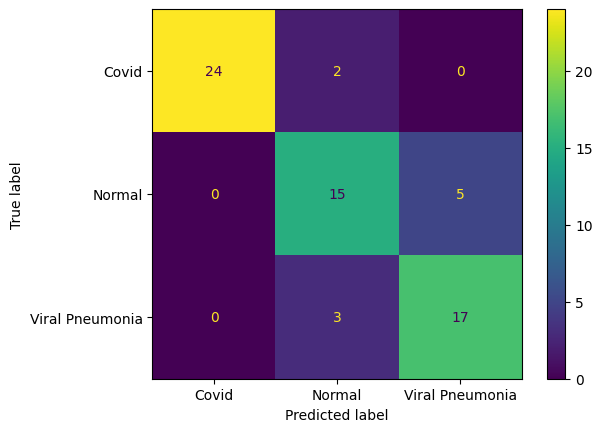

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cd = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = class_names)
cd.plot()
plt.show()

In [ ]:
CM

In [ ]:
print(f"Precision {class_names[0]} : {CM[0,0]/CM[0].sum()}")
print(f"Precision {class_names[1]} : {CM[1,1]/CM[1].sum()}")
print(f"Precision {class_names[2]} : {CM[2,2]/CM[2].sum()}")

print(f"Recall {class_names[0]} : {CM[0,0]/CM[:,0].sum()}")
print(f"Recall {class_names[1]} : {CM[1,1]/CM[:,1].sum()}")
print(f"Recall {class_names[2]} : {CM[2,2]/CM[:,2].sum()}")
